In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [38]:
# Load the training data
train_data = pd.read_csv('training_set_features.csv')

In [39]:
# Load the test data
test_data = pd.read_csv('test_set_features.csv')

In [40]:
df2=pd.read_csv('training_set_labels.csv')

In [41]:
train_data['xyz_vaccine']=df2['xyz_vaccine']
train_data['seasonal_vaccine']=df2['seasonal_vaccine']

In [42]:
# Separate features and targets in training data
X_train = train_data.drop(columns=['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'])
y_train = train_data[['xyz_vaccine', 'seasonal_vaccine']]

In [43]:
# Features for test data
X_test = test_data.drop(columns=['respondent_id'])

In [44]:
# Preprocessing
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_features = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
print(categorical_features)
print(numerical_features)

['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk', 'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']


In [45]:
# Imputation and encoding for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [46]:
# Imputation and encoding for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [47]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [48]:
# Model pipeline
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(xgb))
])

In [49]:
# Train the model on the entire training data
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['xyz_concern',
                                                   'xyz_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'be...
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)))])

In [50]:
# Example with ROC Curve Plotting
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train_split, y_train_split)

y_val_pred_proba = model.predict_proba(X_val_split)
y_val_pred_proba_combined = np.column_stack([proba[:, 1] for proba in y_val_pred_proba])

roc_auc_val = roc_auc_score(y_val_split, y_val_pred_proba_combined, average='macro')
print(f'ROC AUC Score on Validation Data: {roc_auc_val}')

ROC AUC Score on Validation Data: 0.8367407932489053


In [51]:
# Generate ROC curves for each label on the validation data
fpr_val = {}
tpr_val = {}
roc_auc_dict_val = {}

for i, label in enumerate(['xyz_vaccine', 'seasonal_vaccine']):
    fpr_val[label], tpr_val[label], _ = roc_curve(y_val_split.iloc[:, i], y_val_pred_proba_combined[:, i])
    roc_auc_dict_val[label] = auc(fpr_val[label], tpr_val[label])

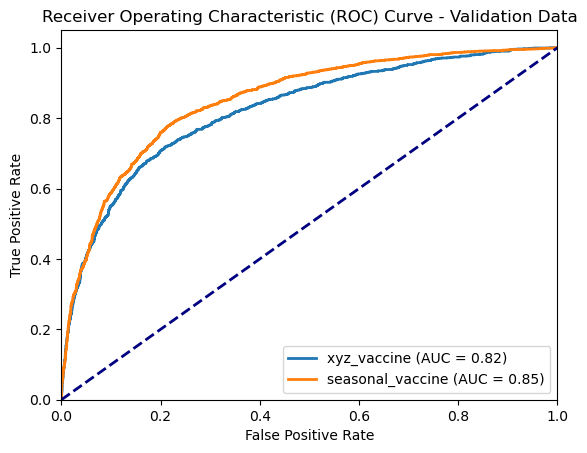

In [52]:
# Plot ROC curves for the validation data
plt.figure()

for label in ['xyz_vaccine', 'seasonal_vaccine']:
    plt.plot(fpr_val[label], tpr_val[label], lw=2, label=f'{label} (AUC = {roc_auc_dict_val[label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Data')
plt.legend(loc="lower right")
plt.show()

In [53]:
# Predict on the separate test data
y_test_pred_proba_full = model.predict_proba(X_test)
test_predictions = pd.DataFrame({
    'respondent_id': test_data['respondent_id'],
    'xyz_vaccine': y_test_pred_proba_full[0][:, 1],
    'seasonal_vaccine': y_test_pred_proba_full[1][:, 1]
})

In [54]:
# Save the submission file
test_predictions.to_csv('submission.csv', index=False)